In [1]:
import pandas as pd
import sqlite3
import numpy as np
import json

def load_data_from_db(dbs, tbl):
    sc = list()
    for i, node in enumerate(dbs):
        conn = sqlite3.connect(node)
        
        query_cmd = f'SELECT *, strftime("%Y-%m-%d %H:%M:%S",timestamp) FROM {tbl} WHERE id IN ( SELECT MAX(id) FROM dbstatus GROUP BY timestamp);'

        df = pd.read_sql_query(query_cmd, conn)
        # df.drop('id', axis=1, inplace=True)
        # df.drop('totalblocks', axis=1, inplace=True)
        # df.drop('totaltransactions', axis=1, inplace=True)
        # df.drop('blocks', axis=1, inplace=True)
        # df = df.rename(columns={'ts': 'timestamp'})
        
        # df.astype({'headers': 'int', 'transactions': 'int', 'size': 'int', 'totalquery': 'int', 
        #           'queryfrom': 'int', 'queryto': 'int', 'totaldelay': 'int'}).dtypes

        # #df['totalhop'] = df['totalhop'].apply(json.loads)
        sc.append(df)        
        conn.close()
    return sc

In [2]:
#calculate centrality
import math
import numpy as np

def entropynorm(values):
    vs = np.array(values)
    num = vs.size
    tt = np.sum(vs)
    vs = vs/tt

    npi = np.sum(vs*np.log2(vs, out=np.zeros_like(vs), where=(vs!=0)))
    dpi = math.log2(num)
    return - npi/dpi

def fairnessnorm(values):
    vs = np.array(values)
    num = vs.size

    npi = np.sum(vs)
    npi = npi**2
    dpi = np.square(vs).sum()
    dpi = dpi*num
    
    fn = (npi/dpi - 1/num) / (1 - 1/num)
    
    return fn

values_list = [
                [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
                [0.17, 0.17, 0.13, 0.12, 0.11, 0.09, 0.07, 0.06, 0.05, 0.03],
                [0.42, 0.2, 0.14, 0.07, 0.04, 0.04, 0.03, 0.03, 0.02, 0.01]
                ]

print(entropynorm(values_list[2]))
print(fairnessnorm(values_list[1]))

0.7556018366014379
0.8056472313898059


In [3]:
import os

#PATH = "../blockchainnode/db_nodes"
# PATH = "../PoS_20221130_083413"
PATH = "../PoS_Starks_20230401"

fdbs = [os.path.join(PATH, f) for f in os.listdir(PATH) if f.split(".")[-1] == 'db']
if len(fdbs) == 0:
    subdirs = [x[0] for x in os.walk(PATH)]
    for subd in subdirs:
        subbs = [os.path.join(subd, f) for f in os.listdir(subd) if f.split(".")[-1] == 'db']
        fdbs.extend(subbs)

fdbs.sort()
print(fdbs)

['../PoS_Starks_20230401/7031.db', '../PoS_Starks_20230401/7032.db', '../PoS_Starks_20230401/7033.db', '../PoS_Starks_20230401/7034.db', '../PoS_Starks_20230401/7035.db', '../PoS_Starks_20230401/7036.db', '../PoS_Starks_20230401/7037.db', '../PoS_Starks_20230401/7038.db']


[49, 39, 49, 33, 47, 43, 52, 54] 366
[317, 327, 317, 333, 319, 323, 314, 312] 2562
Fairness Proof 0.9768954275683358
Entropy Proof 0.9948333630901723


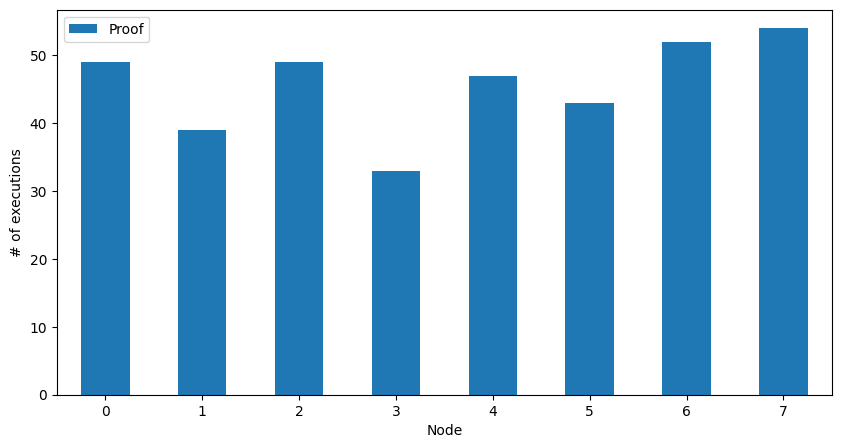

In [4]:
# Count chart for proof and verify
from matplotlib import pyplot as plt
    
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df.shape[0])
print(proof, sum(proof))

dfs = load_data_from_db(fdbs, 'veriftbl')
verif = []
for i, df in enumerate(dfs):
    verif.append(df.shape[0])
print(verif, sum(verif))

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("# of executions")
plt.savefig('Num_Prover_Verifier.png', dpi=300, bbox_inches='tight')

print('Fairness Proof', fairnessnorm(proof))
# print('Fairness Verification', fairnessnorm(verif))

print('Entropy Proof', entropynorm(proof))
# print('Entropy Verification', entropynorm(verif))




Avg Proof[msec] 4291.803449404671
Avg Verif[msec] 1271.3951884208557


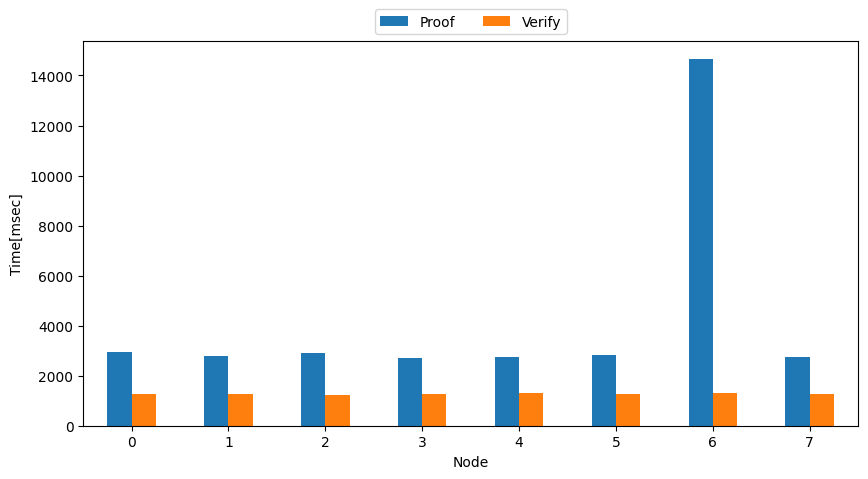

In [5]:
# Avg. Time chart for proof and verify
from matplotlib import pyplot as plt

unit = 1000000 #msec
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['timegenproof'].mean()/unit)
# print(proof)

dfs = load_data_from_db(fdbs, 'veriftbl')
veriffwd = []
# verifrev = []
for i, df in enumerate(dfs):
    veriffwd.append(df['timeveriffwd'].mean()/unit)
    # verifrev.append(df['timeverifrev'].mean()/unit)
# print(veriffwd)
# print(verifrev)

ch_list = [proof, veriffwd]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof', 'Verify']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Time[msec]")
# plt.legend(loc='right')
# ax.set_yscale('log')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          fancybox=True, shadow=False, ncol=5)

plt.savefig('Avg_Time_Proof_Verify.png', dpi=300, bbox_inches='tight')

print('Avg Proof[msec]', sum(proof)/len(proof))
print('Avg Verif[msec]', sum(veriffwd)/len(veriffwd))
# print('Avg Verif Back[msec]', sum(verifrev)/len(verifrev))


Avg size of verification Time T1     162.842736
T2    3098.865446
T3    2936.022710
dtype: float64


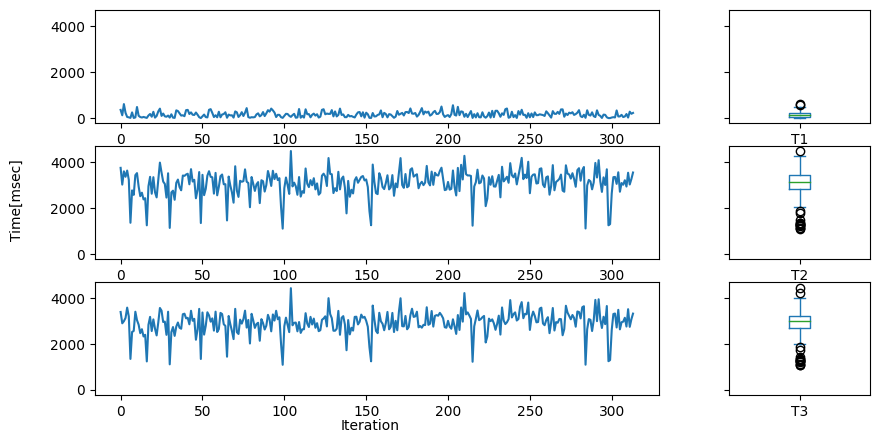

In [10]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'veriftbl')
timelastblock = []
timercvlastblock = []
timercvpos = []
for i, df in enumerate(dfs):
    timelastblock.append(df['timelastblock'])
    timercvlastblock.append(df['timercvlastblock'])
    timercvpos.append(df['timercvpos'])
node = 6
ch_list = [timelastblock[node], timercvlastblock[node], timercvpos[node]]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Last Block', 'Receive Block', 'Receive PoS']

tdf = pd.DataFrame()
tdf['T1'] = (bdf['Receive Block'] - bdf['Last Block'])/1000000
tdf['T2'] = (bdf['Receive PoS'] - bdf['Last Block'])/1000000
tdf['T3'] = (bdf['Receive PoS'] - bdf['Receive Block'])/1000000

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
fig.text(0.04, 0.5, 'Time[msec]', va='center', rotation='vertical')
fig.text(0.4, 0.04, 'Iteration', ha='center')

tdf['T1'].plot.line(ax=axes[0][0])
tdf['T1'].plot.box(ax=axes[0][1])
tdf['T2'].plot.line(ax=axes[1][0])
tdf['T2'].plot.box(ax=axes[1][1])
tdf['T3'].plot.line(ax=axes[2][0])
tdf['T3'].plot.box(ax=axes[2][1])

# plt.xlabel("Iteration")
# plt.ylabel("Time")
plt.savefig('Verifcation_Time.png', dpi=300, bbox_inches='tight')

print('Avg size of verification Time', tdf.mean())


[310.563387755102, 311.17687179487183, 312.6728979591837, 309.5629090909091, 309.9643829787234, 311.45711627906974, 311.23457692307693, 312.7284814814815]
Avg size of proof 311.1700780328023


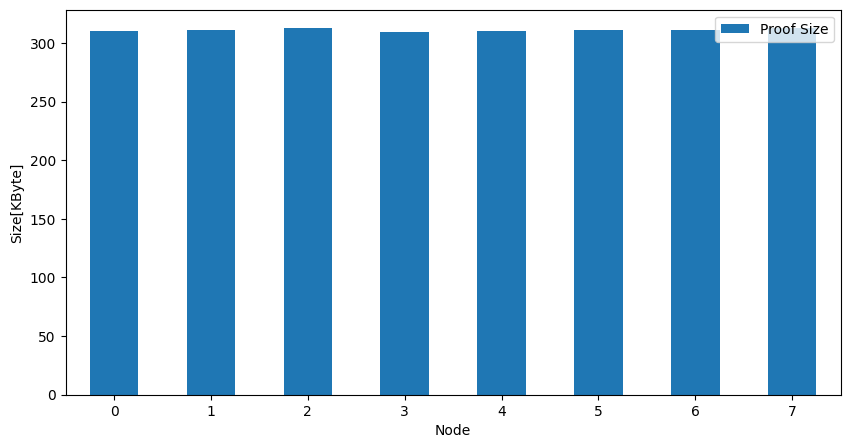

In [7]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt

unit = 1000 #kbyte
dfs = load_data_from_db(fdbs, 'prooftbl')
proof = []
for i, df in enumerate(dfs):
    proof.append(df['sizegenproof'].mean()/unit)
print(proof)

ch_list = [proof]
bdf = pd.DataFrame(ch_list).transpose()
bdf.columns = ['Proof Size']
ax = bdf.plot.bar(rot=0, figsize=(10, 5))
plt.xlabel("Node")
plt.ylabel("Size[KByte]")
plt.savefig('Avg_Size_Proof.png', dpi=300, bbox_inches='tight')

print('Avg size of proof', sum(proof)/len(proof))

In [81]:
# Avg. Size chart for proof 
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def get_dhn_nodes(issum=True):
    unit = 1000000000 #sec
    C = 6.
    Vt = 1.
    Wt = 7.
    dfs = load_data_from_db(fdbs, 'veriftbl')

    nodes = []
    ## Calculate nodes list first
    for i, df in enumerate(dfs):
        nodes.extend(df['nodeaddress'].values.tolist())
    nodes = sorted(set(nodes))
    for n in nodes:
        print(n)


    df_dhn = {}
    for i, df in enumerate(dfs):
        def get_dhn_sum():
            df2 = df.groupby('nodeaddress', sort=True)['Dhn'].sum().reset_index(name ='Dhn')
            for k, n in enumerate(nodes):
                if False == df2['nodeaddress'].isin([n]).any():
                    df2.loc[len(df2)] = [n, 0]
                    idx = k
                    
            df2 = df2.sort_values(by=['nodeaddress'])
            df2 = df2.reset_index()
            return idx, df2
        
        def get_dhn_time_event():
            for k, n in enumerate(nodes):
                if False == df['nodeaddress'].isin([n]).any():
                    idx = k
            data = {}
            for k, n in enumerate(nodes):
                if k != idx:
                    data[n] = [0]
            
            df2=pd.DataFrame(data)
            for k, row in df.iterrows():
                df2.loc[len(df2)] = [row['Dhn'] if row['nodeaddress'] == n else 0 for n in df2.columns]
            return idx, df2
        
        idx = 0
        df['Dhn_0'] = C*(1 - (df['timercvpos'] - df['timelastblock'])/unit/Wt)
        df['Dhn'] = np.exp(df['Dhn_0'])
        
        idx, df2 = get_dhn_sum() if issum == True  else get_dhn_time_event()

        # print(df2)
        df_dhn[idx] = df2
    return nodes, df_dhn


04038d7271df52d8b5d50d124880a609821da8f32b287a10d515c68beb83355e
2b3e69c44037df507fabf4ab44770bf56f33d65d32e97dccbe083a5f3297b8b4
2bffbc3439d1300e3f2caed7192ec63ca39e85eb9e573a2165d43e8010da21b6
43df19f492d5eac461abf840f58c7d97fbfe3f6f2d5f8e6bec47b7e724030a8b
49892d786ce2dc60ce21c50ad20bc69f000a7763b3c5cd0a28199d612900e522
ababe12b547e9f2c96f2df0d03667e72d7716a2a833e4a31d73eba29873cd179
b512652a74f68378abbf68e0cc1a060f51b0476383b739644df8d64392596999
d98318cb612ac00c07961aa792be65ec7745c5c41dec1c85ce9db30e13bb113f


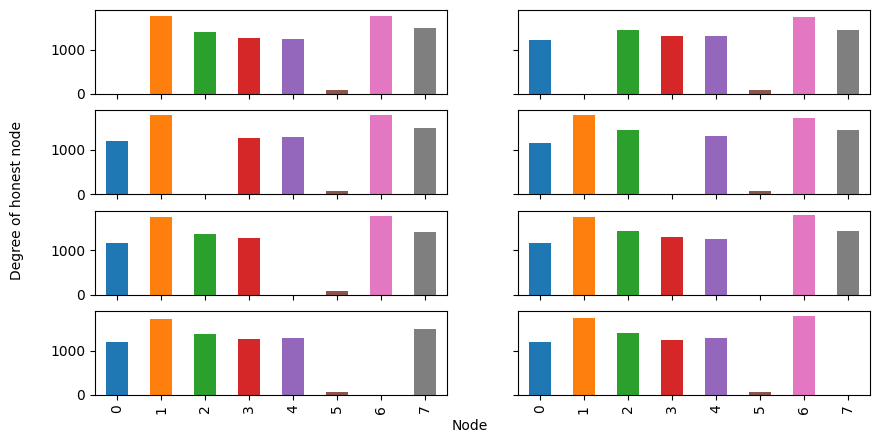

In [82]:
nodes, dfs = get_dhn_nodes()

colormap = {}
colors = mcolors.TABLEAU_COLORS
for i, (n, k) in enumerate(zip(nodes, colors.keys())):
    colormap[n] = colors[k]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 5), sharey=True, sharex=True)
fig.text(0.04, 0.5, 'Degree of honest node', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Node', ha='center')

for idx, df in dfs.items(): 
    if idx%2 == 0:
        df['Dhn'].plot(ax=axes[idx//2][0], kind='bar',  color=df['nodeaddress'].replace(colormap))        
    else:
        df['Dhn'].plot(ax=axes[idx//2][1], kind='bar',  color=df['nodeaddress'].replace(colormap))     
    
plt.savefig('DegreeHonestProver.png', dpi=300, bbox_inches='tight')
plt.show()


04038d7271df52d8b5d50d124880a609821da8f32b287a10d515c68beb83355e
2b3e69c44037df507fabf4ab44770bf56f33d65d32e97dccbe083a5f3297b8b4
2bffbc3439d1300e3f2caed7192ec63ca39e85eb9e573a2165d43e8010da21b6
43df19f492d5eac461abf840f58c7d97fbfe3f6f2d5f8e6bec47b7e724030a8b
49892d786ce2dc60ce21c50ad20bc69f000a7763b3c5cd0a28199d612900e522
ababe12b547e9f2c96f2df0d03667e72d7716a2a833e4a31d73eba29873cd179
b512652a74f68378abbf68e0cc1a060f51b0476383b739644df8d64392596999
d98318cb612ac00c07961aa792be65ec7745c5c41dec1c85ce9db30e13bb113f


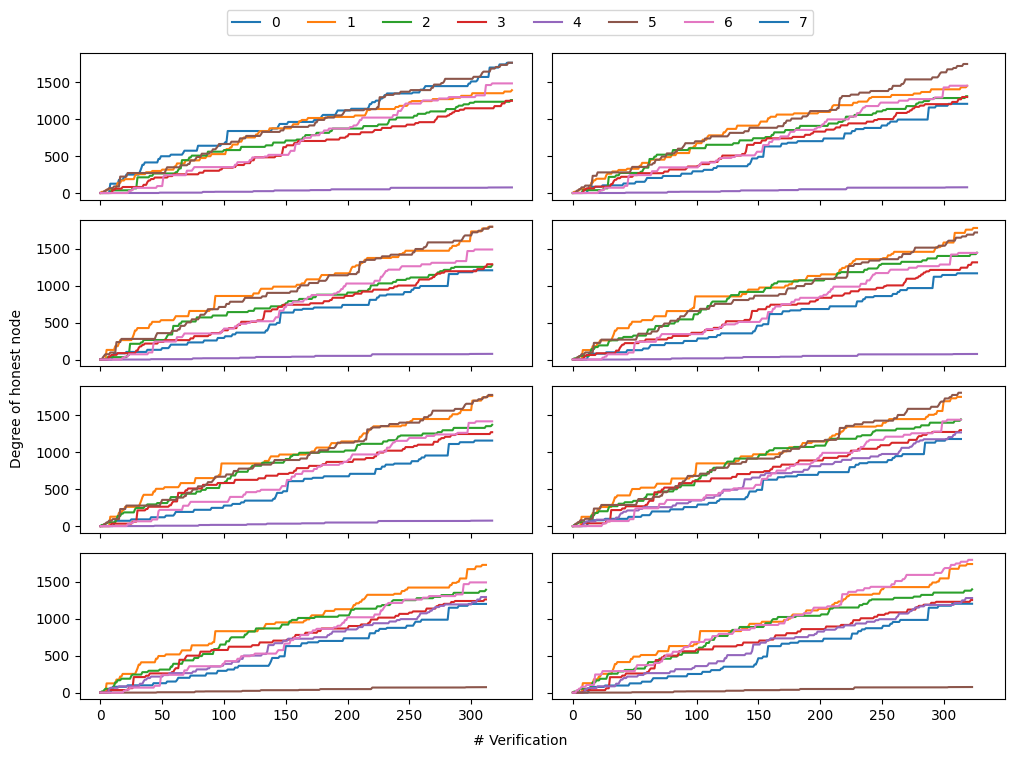

In [112]:
nodes, dfs = get_dhn_nodes(issum=False)

colormap = {}
colors = mcolors.TABLEAU_COLORS
for i, (n, k) in enumerate(zip(nodes, colors.keys())):
    colormap[n] = colors[k]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 7), sharey=True, sharex=True, constrained_layout=False)
fig.text(-0.01, 0.5, 'Degree of honest node', va='center', rotation='vertical')
fig.text(0.5, -0.01, '# Verification', ha='center')
labels = [i for i in range(len(nodes))]

for idx, df in dfs.items(): 
    if idx%2 == 0:
        df.cumsum().plot(ax=axes[idx//2][0], kind='line', legend=None)
    else:
        df.cumsum().plot(ax=axes[idx//2][1], kind='line', legend=None)

fig.tight_layout() 
fig.legend(labels, loc='upper center', ncol=len(labels), bbox_transform=fig.transFigure, bbox_to_anchor=(0.5, 1.05))

# plt.savefig('DegreeHonestProver.png', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
import numpy as np
 
def cal_evenness1(vdf, vmax):
    vdf['weight'] = (vmax - vdf['Height'])
    vdf['norm_cnt1'] = vdf['Count']/vdf['weight']
    values = vdf['norm_cnt1'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    
def cal_evenness2(vdf, vmax):
    vdf['norm_cnt2'] = vdf['Count']*vdf['Height']
    values = vdf['norm_cnt2'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)

def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(max(i, 5), vmax):
            pi += 1/(j-1)
        # pi = pi*np.log10(pi)
        pis.append(pi)
    
    # mpis = max(pis)
    mpis = sum(pis)
    # https://en.wikipedia.org/wiki/Entropy_(information_theory)
    pis2 = [x /mpis for x in pis]
    pis3 = [-np.log2(x) for x in pis2] 
    # print(pis2)
    plt.plot(pis2)
    return pis2, pis3

def cal_evenness3(vdf, vmax):
    # vdf = sdf.copy()
    pis, pis2 = cal_acc_prob(vmax)

    # vdf.set_index('Height', inplace=True)
    # vdf = vdf.reindex(list(range(0,vmax)),fill_value=0)    
    # vdf['weight'] =  pis
    # vdf['weight3'] = [pis2[v] for v in vdf['Height'].values]
    vdf['weight3'] = [1/pis[v] for v in vdf['Height'].values]
    # print('weights',vdf)
    vdf['norm_cnt3'] = vdf['Count']*vdf['weight3']
    # vdf['norm_cnt'] = vdf['Count2']*vdf['weight']

    # plt.plot(vdf['weight3'])

    # values = vdf['Count'].to_list()
    # vs = np.array(values)
    # num = vs.size
    # tt = np.sum(vs)
    # vs = vs/tt
    # # print('p(x)', vs)

    # ci_values =  vdf['weight3'].to_list()
    # ci = np.array(ci_values)
    # # print('CI=====', ci)

    # se = vs*ci
    # npi = np.sum(vs*ci)
    # dpi = math.log2(num)
    # print('Entropy', npi/dpi)
    # plt.plot(vs, 'g')
    # # plt.plot(ci, 'r')
    # plt.plot(se, 'b')

    values = vdf['norm_cnt3'].to_list()
    nf = fairnessnorm(values)
    ne = entropynorm(values)
    print(nf, ne)
    # print(values)
    # plt.plot(values)
    
    # print(vdf['norm_cnt'])
    
    # vdf['norm_cnt'].plot()
cal_evenness1(bdf2, 720)
cal_evenness2(bdf2, 720)
cal_evenness3(bdf2, 720)

# print(bdf2)
# plt.plot(bdf2['norm_cnt1']*50, 'r')
# plt.plot(bdf2['norm_cnt2']/1284, 'b')
# plt.plot(bdf2['norm_cnt3']/20, 'g')



NameError: name 'bdf2' is not defined

In [ ]:
def cal_acc_prob(vmax):
    pis = []
    for i in range(vmax):
        pi = 0
        for j in range(i, vmax):
            pi += 1/(j+1)
        pis.append(pi*np.log10(i+1))
    # print(pis)
    
    return pis
pis = cal_acc_prob(720)
# plt.plot(pis)
bdf = pd.DataFrame([pis]).transpose()
bdf.columns = ['Count']
# ax = bdf.plot.hist(bins=12, label='Count')
bdf2

,Height,Count,weight,norm_cnt1,norm_cnt2,weight3,norm_cnt3
0,1,3,719,0.004172,3,136.372023,409.116069
1,2,3,718,0.004178,6,136.372023,409.116069
2,3,5,717,0.006974,15,136.372023,681.860115
3,4,2,716,0.002793,8,136.372023,272.744046
4,5,2,715,0.002797,10,136.372023,272.744046
...,...,...,...,...,...,...,...
215,628,2,92,0.021739,1256,5296.004112,10592.008224
216,639,1,81,0.012346,639,6066.663008,6066.663008
217,642,1,78,0.012821,642,6314.512680,6314.512680
218,650,1,70,0.014286,650,7079.180691,7079.180691


In [ ]:
from matplotlib import colors as mcolors

strings = [s for s in plt.colormaps() if "_r" not in s]
# print(strings)

color_map = plt.get_cmap(strings[0])
print(color_map.colors)

cmap_str = plt.colormaps()
print(cmap_str)
color_map = plt.get_cmap(cmap_str[0])
print(color_map.colors)

[[0.001462, 0.000466, 0.013866], [0.002258, 0.001295, 0.018331], [0.003279, 0.002305, 0.023708], [0.004512, 0.00349, 0.029965], [0.00595, 0.004843, 0.03713], [0.007588, 0.006356, 0.044973], [0.009426, 0.008022, 0.052844], [0.011465, 0.009828, 0.06075], [0.013708, 0.011771, 0.068667], [0.016156, 0.01384, 0.076603], [0.018815, 0.016026, 0.084584], [0.021692, 0.01832, 0.09261], [0.024792, 0.020715, 0.100676], [0.028123, 0.023201, 0.108787], [0.031696, 0.025765, 0.116965], [0.03552, 0.028397, 0.125209], [0.039608, 0.03109, 0.133515], [0.04383, 0.03383, 0.141886], [0.048062, 0.036607, 0.150327], [0.05232, 0.039407, 0.158841], [0.056615, 0.04216, 0.167446], [0.060949, 0.044794, 0.176129], [0.06533, 0.047318, 0.184892], [0.069764, 0.049726, 0.193735], [0.074257, 0.052017, 0.20266], [0.078815, 0.054184, 0.211667], [0.083446, 0.056225, 0.220755], [0.088155, 0.058133, 0.229922], [0.092949, 0.059904, 0.239164], [0.097833, 0.061531, 0.248477], [0.102815, 0.06301, 0.257854], [0.107899, 0.064335, 0.